In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving test.csv to test.csv
Saving train.csv to train.csv
User uploaded file "test.csv" with length 2331766 bytes
User uploaded file "train.csv" with length 4794242 bytes


In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [ ]:
train_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,2463,Dementia Therapy Targeting Tau.,tau microtubul associ tau protein also non mic...,Alternative Splicing; Alzheimer Disease; Demen...,0,0,0,1,0
1,2511,[Acute neuropsychiatry: a confused patient and...,anti nmda receptor enceph progress autoimmun d...,Acute Disease; Anti-N-Methyl-D-Aspartate Recep...,0,0,0,1,0
2,2227,A systematic review and meta-analysis of safet...,safinamid recent develop drug sever mechan act...,Add-on; Dopamine; Dopamine agonist; Motor; Mov...,0,0,0,1,0
3,526,Emotional intelligence and systolic blood pres...,present studi design compar emot intellig ei c...,Hear t Failure; Mean arterial pressure; Cogni...,1,0,0,0,0
4,4291,Necrotising fasciitis caused by aeromonas sobr...,necrotis fasciiti life threaten infect soft ti...,"Aeromonas; Animals; Catfishes; Diagnosis, Diff...",0,0,0,0,1
5,2986,Development of a Sleep Apnea Detection Algorit...,sleep apnea syndrom sa preval disord caus dayt...,"Algorithms; Heart Rate; Humans; Memory, Short-...",0,0,0,1,0
6,1842,Prevalence of Cryptosporidium spp. infection a...,cryptosporidium spp identifi import caus diarr...,Child; Cross-Sectional Studies; Cryptosporidio...,0,1,0,0,0
7,1142,Awareness of smoking in adolescents with infla...,inflammatori bowel diseas ibd long life diseas...,Crohn...s disease; Ulcerative colitis; environ...,0,1,0,0,0
8,3371,Immune response during influenza virus infecti...,pathogen influenza viru infect modul cytokin e...,Cytokine; Northeast India; influenza virus; pa...,0,0,0,0,1
9,5349,Identification of Ppar<i>..</i>-modulated miRN...,liver fibrosi interfer normal liver function f...,PPAR..; fibrosis; hepatocellular carcinoma; mi...,0,0,1,0,0


In [ ]:
test_df.head(10)

,Unnamed: 0,title,abstract,keywords,Cardio,Diges,Resp,Nerv,Infe
0,3,Multi-organ trauma with rupture and Stanford t...,case year old car driver struck great forc tra...,blunt thoracic aortic injury (BTAI); lateral c...,1,0,0,0,0
1,4,Anticoagulant treatment in elderly patients wi...,atrial fibril af common elderli treatment cond...,anticoagulation therapy; atrial fibrillation; ...,1,0,0,0,0
2,6,Does characterising patterns of multimorbidity...,stroke transient ischaem attack tia remain lea...,integrated care; interprofessional collaborati...,1,0,0,0,0
3,8,Biological agent in prevention of ocular recur...,ocular involv beh et diseas bd character recur...,"Adalimumab; Administration, Oral; Adult; Anti-...",1,0,0,0,0
4,9,Lens induced glaucoma in a tertiary eye care c...,len induc glaucoma due hypermatur cataract imp...,Aged; Cataract; Cataract Extraction; Eye Pain;...,1,0,0,0,0
5,11,Ventricular bigeminy in enteric fever.,salmonella infect caus wide rang intestin extr...,Adult; Anti-Bacterial Agents; Electrocardiogra...,1,0,0,0,0
6,14,TORSADES DE POINTES IN ELDERLY PATIENT WITH PA...,one drug wide use treatment atrial fibril amio...,Amiodarone; Atrial fibrillation; Bradycardia; ...,1,0,0,0,0
7,15,Transcatheter InterAtrial Shunt Device for the...,random sham control trial patient heart failur...,Cardiac Catheterization; Double-Blind Method; ...,1,0,0,0,0
8,22,[Endothelial dysfunction in patients with cont...,conduct compar analysi level asymmetr dimethyl...,arterial hypertension; asymmetric dimethylargi...,1,0,0,0,0
9,23,[Autoantibodies to M2-cholinoreceptors as a po...,aim assess autoantibodi m2 cholinoceptor m2 cr...,M2 cholinoceptors; arterial hypertension; atri...,1,0,0,0,0


In [ ]:
print('Processing text dataset')
from nltk.tokenize import WordPunctTokenizer
from collections import Counter
from string import punctuation, ascii_lowercase
import regex as re
from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')

vocab = Counter()

def text_to_wordlist(text, lower=False):
  text = tokenizer.tokenize(text)
  text = [w for w in text if len(w) != 1]
  vocab.update(text)
  return text

def process_comments(list_sentences, lower=False):
    comments = []
    for text in tqdm(list_sentences):
        txt = text_to_wordlist(text, lower=lower)
        comments.append(txt)

    return comments

list_sentences_train = list(train_df["keywords"].fillna("NAN_WORD").values)
list_sentences_test = list(test_df["keywords"].fillna("NAN_WORD").values)

#Todas las keywords
comments = process_comments(list_sentences_train + list_sentences_test, lower=True)

 43%|████▎     | 2327/5417 [00:00<00:00, 11828.98it/s]

Processing text dataset


100%|██████████| 5417/5417 [00:00<00:00, 11864.51it/s]


In [ ]:
print("The vocabulary contains {} unique tokens".format(len(vocab)))

The vocabulary contains 13638 unique tokens


In [ ]:
from gensim.models.fasttext import FastText
model = FastText(comments, size=150, window=5, min_count=5, workers=16, sg=1)

word_vectors = model.wv
print("Number of word vectors: {}".format(len(word_vectors.vocab)))

Number of word vectors: 11043


In [ ]:
# Shape of the vector
model.wv['cardiovascular'].shape

(150,)

In [ ]:
# Top 10 closest words in %
model.wv.most_similar("cardiovascular", topn=10)

[('cardiovasculair', 0.9193323850631714),
 ('cardiovers', 0.8747420907020569),
 ('cardiovert', 0.856606125831604),
 ('cardiovascolari', 0.8451527953147888),
 ('cerebrovascular', 0.8430348038673401),
 ('cardioren', 0.8415740728378296),
 ('cardiotox', 0.821982204914093),
 ('cardiovascolar', 0.8190021514892578),
 ('neurovascular', 0.8113503456115723),
 ('neovascular', 0.8070548176765442)]

In [ ]:
# Closeness evaluation between words in %
model.wv.similarity("cardiovascular", "arter") 

0.5064654

In [ ]:
# Top 10 least close words in %
model.wv.most_similar(negative=["cardiovascular"], topn=10)

[('NAN_WORD', -0.04746399074792862),
 ('spf', -0.08584988862276077),
 ('sp', -0.09783400595188141),
 ('ov', -0.10501231253147125),
 ('water', -0.11182280629873276),
 ('fe', -0.1127556636929512),
 ('bla', -0.11301356554031372),
 ('fecal', -0.11699586361646652),
 ('sequenc', -0.11816726624965668),
 ('stain', -0.12219765037298203)]

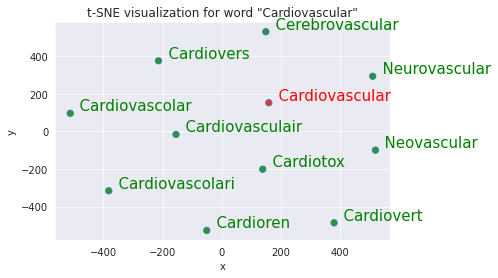

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
from sklearn.manifold import TSNE
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
from nltk.tokenize import RegexpTokenizer

# tsne plot for below word
# for_word = 'food'
def tsne_plot(for_word, w2v_model):
    # trained word2vec model dimention
    dim_size = w2v_model.wv.vectors.shape[1]

    arrays = np.empty((0, dim_size), dtype='f')
    word_labels = [for_word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, w2v_model.wv.__getitem__([for_word]), axis=0)

    # gets list of most similar words
    sim_words = w2v_model.wv.most_similar(for_word, topn=10)

    # adds the vector for each of the closest words to the array
    for wrd_score in sim_words:
        wrd_vector = w2v_model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)

    #---------------------- Apply PCA and tsne to reduce dimention --------------

    # fit 2d PCA model to the similar word vectors
    model_pca = PCA(n_components = 10).fit_transform(arrays)

    # Finds 2d coordinates t-SNE
    np.set_printoptions(suppress=True)
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(model_pca)

    # Sets everything up to plot
    df_plot = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words_name': word_labels,
                       'words_color': color_list})

    #------------------------- tsne plot Python -----------------------------------

    # plot dots with color and position
    plot_dot = sns.regplot(data=df_plot,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df_plot['words_color']
                                 }
                    )

    # Adds annotations with color one by one with a loop
    for line in range(0, df_plot.shape[0]):
         plot_dot.text(df_plot["x"][line],
                 df_plot['y'][line],
                 '  ' + df_plot["words_name"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df_plot['words_color'][line],
                 weight='normal'
                ).set_size(15)


    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)

    plt.title('t-SNE visualization for word "{}'.format(for_word.title()) +'"')

# tsne plot for top 10 similar word
tsne_plot(for_word='cardiovascular', w2v_model=model)

In [ ]:
word_vectors['coronary']

array([ 0.00903315, -0.24725196,  0.36772525,  0.12085838, -0.01573852,
       -0.01496392,  0.5008691 ,  0.10001492, -0.16391651, -0.53520864,
       -0.5167156 ,  0.22432376,  0.42675915, -0.27549765, -0.23272534,
        0.51766783, -0.15204857, -0.20063311, -0.23493992, -0.05219831,
       -0.3062075 , -0.19535802,  0.47767568,  0.16503048, -0.144256  ,
       -0.20319875,  0.06593741,  0.29115206, -0.16081297,  0.03288211,
       -0.02547089,  0.04621844,  0.274632  ,  0.13710548,  0.14562015,
        0.01701135, -0.59376025, -0.05351496, -0.35598004,  0.03061186,
       -0.49367866,  0.11337503,  0.04439215, -0.08238869, -0.05734811,
        0.78172755, -0.14452799,  0.14929987, -0.33835003,  0.06354015,
        0.35473007, -0.1492128 , -0.18139923,  0.24014318,  0.2654036 ,
       -0.53969514, -0.02138302, -0.05258958, -0.50557685,  0.00240416,
       -0.24345726, -0.34533456, -0.28347304, -0.22151092,  0.09933619,
        0.06740732, -0.37791106,  0.1253968 ,  0.31490403,  0.32

In [ ]:
#Definimos el tamaño de los vectores. Al estar trabajando con keywords podemos escoger un tamaño que no sea muy grane
MAX_NB_WORDS = len(word_vectors.vocab)
MAX_SEQUENCE_LENGTH = 30

In [ ]:
from keras.preprocessing.sequence import pad_sequences

#Diccionario con todas las palabras asignadas un i + 1. 
word_index = {t[0]: i+1 for i,t in enumerate(vocab.most_common(MAX_NB_WORDS))}

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TRAIN)
sequences = [[word_index.get(t, 0) for t in comment]
             for comment in comments[:len(list_sentences_train)]]

#Para cada una de las palabras de los articulos le damos su valor de word_index (en el caso de TEST)
test_sequences = [[word_index.get(t, 0)  for t in comment] 
                  for comment in comments[len(list_sentences_train):]]

# Mediante la funcion pad_sequences recortamos los vectores de keywords a una longitud determinada, en este caso 20. 
#Ajuste del tamaño para TRAIN
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, 
                     padding="pre", truncating="post")
list_classes = ["Cardio", "Diges", "Resp", "Nerv", "Infe"]
y = train_df[list_classes].values
print('Shape de los tensores training (data):', data.shape)
print('Shape de los tensores label del training (y):', y.shape)

#Ajuste del tamaño para TEST
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post",
                          truncating="post")
print('Shape de los tensores del test (test_data):', test_data.shape)

Shape de los tensores training (data): (3629, 30)
Shape de los tensores label del training (y): (3629, 5)
Shape de los tensores del test (test_data): (1788, 30)


In [ ]:
# Comprobamos la correspondencia entre ambos vectores, es decir, que tengan el mismo valor (mismo número) que en el diccionario generado (word_index)
#COMPROBACION TEST
list_sentences_test[9]

'M2 cholinoceptors; arterial hypertension; atrial fibrillation; autoantibodies; Atrial Fibrillation; Autoantibodies; Electrocardiography; Electrocardiography, Ambulatory; Humans; Hypertension'

In [ ]:
#longitud original
print(test_sequences[0])

[0, 2332, 1293, 309, 0, 1741, 0, 0, 2234, 2421, 2030, 2332, 0, 1293, 2841, 0, 1527, 1293, 0, 216, 1575, 1821, 325, 3486, 325, 0, 1038, 313, 227, 325, 313, 1, 3, 7, 2, 135, 1146, 313, 134, 24, 22, 207, 110, 126]


In [ ]:
word_index['thoracic']

2332

In [ ]:
#longitud despues del padding
test_data[0]

array([11817,  2332,  1293,   309, 11818,  1741, 11819, 11820,  2234,
        2421,  2030,  2332,  3791,  1293,  2841, 11821,  1527,  1293,
       11822,   216], dtype=int32)

In [ ]:
#COMPROBACION TRAIN
list_sentences_train[0]

'Alternative Splicing; Alzheimer Disease; Dementia; Humans; Tauopathies; tau Proteins'

In [ ]:
#longitud original
sequences[0]

[3581, 3582, 147, 9, 350, 1, 1022, 580, 40]

In [ ]:
word_index['Alternative']

In [ ]:
#longitud despues del padding
data[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  147,    9,  350,    1, 1022,  580,   40], dtype=int32)

In [ ]:
#ETIQUETAS
y

array([[0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0],
       ...,
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0]])

In [ ]:
# Preparacion de la embedding matrix

WV_DIM = 300
nb_words = min(MAX_NB_WORDS, len(word_vectors.vocab))

# we initialize the matrix with random numbers
wv_matrix = (np.random.rand(nb_words, WV_DIM) - 0.5) / 5.0

#hacemos la embedding matrix con los vectores del word2vec
for word, i in word_index.items():
    if i >= MAX_NB_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        # words not found in embedding index will be all-zeros.
        wv_matrix[i] = embedding_vector
    except:
        pass 

In [ ]:
from keras.layers import Dense, Input, LSTM, Embedding, Dropout,SpatialDropout1D, Bidirectional
from keras.models import Model
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
import keras

#añadimos un control de forma que si se dan dos epocas sin mejorar accuracy se corta el entrenamiento y se escoge el mejor modelo. 
callbacks_list = [keras.callbacks.EarlyStopping(
                  monitor='accuracy',
                  patience=3,),
                  keras.callbacks.ModelCheckpoint(
                  filepath='my_model.h5',
                  monitor='val_loss',
                  save_best_only=True,)]

wv_layer = Embedding(nb_words,
                     WV_DIM,
                     mask_zero=False,
                     weights=[wv_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False)

# Inputs
comment_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = wv_layer(comment_input)

# biGRU
embedded_sequences = SpatialDropout1D(0.2)(embedded_sequences)
x = Bidirectional(LSTM(128, return_sequences=False))(embedded_sequences)

# Output
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
preds = Dense(5, activation='softmax')(x)

# build the model
model = Model(inputs=[comment_input], outputs=preds)
model.compile(loss='mae',
              optimizer='rmsprop',
              metrics=['accuracy']) 

In [ ]:
model.summary() 

Model: "functional_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        [(None, 30)]              0         
_________________________________________________________________
embedding_16 (Embedding)     (None, 30, 150)           537000    
_________________________________________________________________
spatial_dropout1d_16 (Spatia (None, 30, 150)           0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 256)               285696    
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 1285      
Total params: 823,981
Trainable params: 286,981
Non-trainable params: 537,000
_________________________________________

In [ ]:
LSTM_keywords_FastText = model.fit([data], y, validation_split=0.1,
                 epochs=30, batch_size=150, shuffle=True)

#val --> resultado con los test
# loss y val_loss deben tener casi el mismo valor y el mas bajo posible del orden de ~0,01
# si loss < val_loss --> overfitting
# si loss > val_loss --> underfitting 

Epoch 1/30
22/22 [==============================] - 9s 277ms/step - loss: 0.2955 - accuracy: 0.2843 - val_loss: 0.3101 - val_accuracy: 0.3388
Epoch 2/30
22/22 [==============================] - 5s 240ms/step - loss: 0.2138 - accuracy: 0.4998 - val_loss: 0.3039 - val_accuracy: 0.4793
Epoch 3/30
22/22 [==============================] - 5s 244ms/step - loss: 0.1956 - accuracy: 0.5371 - val_loss: 0.3022 - val_accuracy: 0.4518
Epoch 4/30
22/22 [==============================] - 5s 242ms/step - loss: 0.1818 - accuracy: 0.5684 - val_loss: 0.2992 - val_accuracy: 0.5234
Epoch 5/30
22/22 [==============================] - 5s 241ms/step - loss: 0.1685 - accuracy: 0.5990 - val_loss: 0.2898 - val_accuracy: 0.4601
Epoch 6/30
22/22 [==============================] - 5s 239ms/step - loss: 0.1677 - accuracy: 0.6019 - val_loss: 0.2885 - val_accuracy: 0.5124
Epoch 7/30
22/22 [==============================] - 5s 250ms/step - loss: 0.1582 - accuracy: 0.6228 - val_loss: 0.2799 - val_accuracy: 0.4738
Epoch 

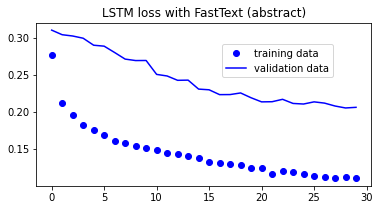

In [ ]:
history = pd.DataFrame(LSTM_keywords_FastText.history)
plt.figure(figsize=(6,3));
plt.plot(history["loss"], 'bo', label='training data'); #puntos
plt.plot(history["val_loss"], 'b', label='validation data'); #linea
plt.title("LSTM loss with FastText (keywords)");
plt.legend(bbox_to_anchor=(0.9, 0.9))
plt.show();

In [1]:
history = pd.DataFrame(LSTM_keywords_FastText.history)
plt.figure(figsize=(6,3));
plt.plot(history["accuracy"], 'bo', label='training data'); #puntos
plt.plot(history["val_accuracy"], 'b', label='validation data'); #linea
plt.title("LSTM accuracy with FastText (abstract)");
plt.legend(bbox_to_anchor=(0.9, 0.3))
plt.show();

NameError: ignored